In [1]:
import numpy as np 
from matplotlib import pyplot as plt
import cv2 

# Mixture Components Merging

In [2]:
def merge_two_modes(mui, muj, Pi, Pj, wi, wj): # w here are log-weights
    # Compute expressions given by (12)
    w_star = np.max([wi, wj])
    wij = w_star + np.log(np.exp(wi - w_star) + np.exp(wj - w_star))
    wi_ij = np.exp(wi - wij)
    wj_ij = np.exp(wj - wij)
    wij_ij = np.exp(wi + wj - 2*wij)
    muij = (wi_ij * mui + wj_ij * muj)
    Pij = (wi_ij * Pi + wj_ij * Pj + wij_ij * (mui - muj)**2)
    # Compute the B(i,j)
    Bij = 0.5 * (np.exp(wij) * np.log(Pij) - np.exp(wi) * np.log(Pi) - np.exp(wj) * np.log(Pj))
    return muij, Pij, wij, Bij

def merge_modes_kld(mu, P, w, M_min, lamda): # w here are log weights
    mu_new = mu.copy()
    P_new = P.copy()
    w_new = w.copy()
    if mu_new.shape[0] <= M_min:
        return mu_new, P_new, w_new
    # Compute Bij matrix
    N = mu_new.shape[0] # number of modes
    B_mat = np.zeros((N,N))
    mu_mat = np.zeros((N,N))
    P_mat = np.zeros((N,N))
    w_mat = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            if i > j:
                muij, Pij, wij, Bij = merge_two_modes(mu_new[i], mu_new[j], P[i], P[j], w[i], w[j])
                B_mat[i,j] = Bij
                mu_mat[i,j] = muij
                P_mat[i,j] = Pij
                w_mat[i,j] = wij
            else:
                B_mat[i,j] = np.inf
    if np.min(B_mat) > lamda: # prevent merging modes that are too far apart
        return mu_new, P_new, w_new
    # Get the pairs of modes to be merged, which correspond to the minimum of the Bij matrix
    i_star, j_star = np.unravel_index(np.argmin(B_mat), B_mat.shape)
    # Replace mode i with the merged mode
    mu_new[i_star] = mu_mat[i_star,j_star]
    P_new[i_star] = P_mat[i_star,j_star]
    w_new[i_star] = w_mat[i_star,j_star]
    # Delete mode j
    mu_new = np.delete(mu_new, j_star, axis=0)
    P_new = np.delete(P_new, j_star, axis=0)
    w_new = np.delete(w_new, j_star, axis=0)
    if np.isnan(mu_new).any() or np.isnan(P).any() or np.isnan(w).any():
        raise Exception('NaN encountered in merge_modes_kld')
    return merge_modes_kld(mu_new, P_new, w_new, M_min, lamda)

In [3]:
# # Unit test for merge_two_modes
# P_k_kPlus1 =  np.array([1.24851222, 1.24851222, 1.24851222, 1.24851222, 1.24851222, 1.24851222,\
#  1.24851222, 1.24851222, 1.24851222])
# mu_k_kPlus1 =  np.array([61.89702318, 60.39702318, 58.89702318, 60.60344188, 59.10344188, 57.60344188,\
#  59.30986058, 57.80986058, 56.30986058])
# w_k_kPlus1 =  np.log(np.array([0.00148396, 0.02671136, 0.00148396, 0.04516887, 0.81303958, 0.04516887,\
#  0.00334717, 0.06024907, 0.00334717]))

# plot_gmm(mu_k_kPlus1, P_k_kPlus1, np.exp(w_k_kPlus1))
# mu_x, Px, wx = merge_modes_kld(mu_k_kPlus1, P_k_kPlus1, w_k_kPlus1, 3, 0.1)
# plot_gmm(mu_x, Px, np.exp(wx))

# Log-Sum-Exp (LSE) for Weight Normalization

In [4]:
def lse(weights):
    # Weight normalization by the Log Sum Exp trick
    w_max = np.max(weights)
    weights_n = np.zeros_like(weights)
    for i in range(weights.shape[0]):
        weights_n[i] = weights[i] - w_max - np.log(np.sum(np.exp(weights - w_max)))
    return weights_n

# Mixture Variance Computation

In [5]:
def get_var_from_mixture(mu, P, w):
    N_components = mu.shape[0]
    mumami = np.sum(mu * w)
    varami = 0
    for i in range(N_components):
        varami += w[i] * (P[i] + (mu[i]**2))
    varami -= mumami**2
    return varami

# Gaussian Mixture Kalman Filter (GMKF)

In [6]:
# In this notebook, we implemement the Gaussian Mixture Kalman Filter (GMKF) from Wills et. al. 2017

from scipy.stats import norm
from sklearn.mixture import GaussianMixture

class GMKF():
    def __init__(self, x_init, std_x, y_init, std_y, v_init, std_v, dynamics_params, x_mean, y_mean, v_mean, std_zx, std_zy, N_max = 5) -> None:
        # mean trajectories
        self.x_mean = x_mean
        self.y_mean = y_mean
        self.v_mean = v_mean

        # time variable
        self.t = 0

        # these are also p(x_1 | y_1) or 1|1, or t|t
        self.N = 1 # initial number of mixture components for lateral component

        # Lateral component
        self.wx = np.array([1])
        self.mu_x = np.array([x_init])
        self.std_x = np.array([std_x])
        self.P_x = np.array([std_x**2])

        # Longitudinal component
        self.wy = np.array([1])
        self.mu_y = np.array([y_init, v_init]).T
        self.std_y = np.array([std_y])
        self.std_v = np.array([std_v])
        self.P_y = np.array([[std_y**2, 0], [0, std_v**2]])

        # Dynamics model
        # dynamics params is a tuple of alpha_left, mu_left, std_left, alpha_center, mu_center, std_center, alpha_right, mu_right, std_right, std_v
        self.dynamics_params = dynamics_params 
        self.Nx = 3 # number of mixture components of the dynamics model for the lateral component
        self.N_max = N_max # maximum number of mixture components for the lateral component
        self.preliminary_pruning_weight_thres = 1e-3 # preliminary pruning weight threshold
        self.em_particles = 5_000 # number of particles for EM resampling of the mixture
        self.A = np.array([[1, 1], [0, 1]])
        self.B = np.array([[0], [1]])
        self.C = np.array([[1, 0]])

        # Measurement model
        self.std_zx = np.array([std_zx])
        self.std_zy = np.array([std_zy]) # STD of velocity actually
        self.P_zx = np.array([std_zx**2])
        self.P_zy = np.array([std_zy**2]) # VAR of velocity actually
        self.Q = np.array([[0,0],[0,self.P_zy[0]]]) # process noise for longitudinal component
        # Whole trajectory for smoothing
        self.mu_x_post = []
        self.P_x_post = []
        self.w_x_post = []
        self.mu_y_post = []
        self.P_y_post = []
        self.w_y_post = []

    def predict(self): # p(x_{t+1} | y_{1:t})
        print('Predicting t = {} -> {}'.format(self.t, self.t + 1))
        # predict the state of the system at the next time step
        # the prediction is a mixture of Gaussians

        # ================== #
        # For lateral/lane change dynamics/x #
        # ================== #
        # first, we compute the number of mixture components in the prediction t+1|1:t
        N_tPlus1_t = self.N * self.Nx # N is the number of components for t|t, Nx is the number of components for t+1|t or the dynamics model
        # then, we compute the means of each mixture component
        
        mu_x_pred = np.zeros(N_tPlus1_t)
        P_x_pred = np.zeros(N_tPlus1_t)
        w_x_pred = np.zeros(N_tPlus1_t)

        for s in range(self.N): # s is the index of t|t mixture
            for j in range(self.Nx): # j is the index of t+1|t mixture, or the dynamics model. j=0: left, j=1: center, j=2: right
                l = self.Nx * s + j # lth mixture component of t+1|1:t
                
                mu_x_pred[l] = (self.x_mean[self.t+1] - self.x_mean[self.t]) + self.mu_x[s] + self.dynamics_params[1 + 3*j] # 1, 4, 7 are the means of the dynamics model
                # in dynamics_params, the variances are at index 2, 5, 8
                P_x_pred[l] = self.P_x[s] + self.dynamics_params[2 + 3*j]**2 # the variance is the sum of the variances of the dynamics and the measurement, 2, 5, 8 are the variances of the dynamics model
                w_x_pred[l] = self.wx[s] * self.dynamics_params[0 + 3*j] # the weight is the product of the weights of the dynamics and the measurement

        # ================== #
        # For longitudinal dynamics/y #
        # ================== #
        # For longitudinal component, there is just one mixture component, so it's similar to a regular Kalman Filter
        # Position
        y_tPlus1_t = self.A @ self.mu_y + np.array([0, self.v_mean[self.t+1] - self.v_mean[self.t]]) # mean propagation of the state # 2x1
        P_tPlus1_t = self.A @ self.P_y @ self.A.T + self.Q # propagation of covariance matrix
        w_tPlus1_t = self.wy[0]

        # at the end of the prediction step, we have 3x the number of mixture components for the state
        return mu_x_pred, P_x_pred, w_x_pred, y_tPlus1_t, P_tPlus1_t, w_tPlus1_t
    
    def update(self, zx, zy, prediction): # zx: the measured lateral (x) and longitudinal (y) position of the vehicle
        print('Updating t = {}'.format(self.t + 1))
        # the update follows Will's 2017 paper. 
        # prediction argument should come from self.predict()
        mu_x_pred, P_x_pred, w_x_pred, mu_y_pred, P_y_pred, w_y_pred = prediction

        # ================== #
        # For lateral/lane change dynamics/x #
        # ================== #
        # the number of posterior mixture components 
        N_tPlus1_t = mu_x_pred.shape[0]
        N_tPlus1_tPlus1 = N_tPlus1_t # because the measurement mixture has only one component
        mu_x_tPlus1_tPlus1 = np.zeros(N_tPlus1_tPlus1)
        P_x_tPlus1_tPlus1 = np.zeros(N_tPlus1_tPlus1)
        w_x_tPlus1_tPlus1 = np.zeros(N_tPlus1_tPlus1)

        for l in range(N_tPlus1_t):
            # compute the predicted measurement covariance
            sigma_tl = P_x_pred[l] + self.P_zx[0] 
            # compute the Kalman gain
            K_tl = P_x_pred[l] / sigma_tl
            # compute the posterior mean
            ex = zx - mu_x_pred[l]
            mu_x_tPlus1_tPlus1[l] = mu_x_pred[l] + K_tl * ex
            # compute the posterior covariance
            P_x_tPlus1_tPlus1[l] = P_x_pred[l] - K_tl * P_x_pred[l]
            # compute the posterior weight
            w_x_tPlus1_tPlus1[l] = w_x_pred[l] * norm.pdf(ex, 0, np.sqrt(sigma_tl))
            
        # Renormalize the weights
        w_x_tPlus1_tPlus1 = w_x_tPlus1_tPlus1 / np.sum(w_x_tPlus1_tPlus1)

        # ================== #
        # PRUNING OF MIXTURE COMPONENTS USING KULLBACK-LEIBLER GMM REDUCTION #
        # ================== #
        
        # convert the weights to log-weights
        w_x_tPlus1_tPlus1 = np.log(w_x_tPlus1_tPlus1)
        # prune the components
        mu_x_tPlus1_tPlus1, P_x_tPlus1_tPlus1, w_x_tPlus1_tPlus1 = merge_modes_kld(mu_x_tPlus1_tPlus1, P_x_tPlus1_tPlus1, w_x_tPlus1_tPlus1, self.N_max, 0.1)
        # convert the log-weights back to the weights
        w_x_tPlus1_tPlus1 = np.exp(w_x_tPlus1_tPlus1)

        # ================== #
        # For longitudinal dynamics/y #
        # ================== #
        # Like said, the longitudinal component is similar to a regular Kalman Filter
        # so there is only one mixture component
        # compute the predicted measurement covariance
        sigma_yt = self.C @ P_y_pred @ self.C.T + self.P_zy[0] # scalar
        # compute the Kalman gain
        K_yt = P_y_pred @ self.C.T / sigma_yt # 2x1
        # compute the posterior mean
        ey = zy - self.C @ mu_y_pred
        mu_y_tPlus1_tPlus1 = mu_y_pred + (K_yt * ey).flatten() # 1x2
        # compute the posterior covariance
        P_y_tPlus1_tPlus1 = P_y_pred - K_yt @ self.C @ P_y_pred # 2x2
        # P_y_tPlus1_tPlus1 = P_y_pred - K_yt * sigma_yt * K_yt.T # 2x2 # original equation in the paper, but it's wrong?
        # compute the posterior weight
        w_y_tPlus1_tPlus1 = np.array([w_y_pred])

        return mu_x_tPlus1_tPlus1, P_x_tPlus1_tPlus1, w_x_tPlus1_tPlus1, sigma_tl, mu_y_tPlus1_tPlus1, P_y_tPlus1_tPlus1, w_y_tPlus1_tPlus1, sigma_yt

    def state_write(self, updaton):
        # updaton is the output of self.update()
        mu_x_tPlus1_tPlus1, P_x_tPlus1_tPlus1, w_x_tPlus1_tPlus1, sigma_tl, mu_y_tPlus1_tPlus1, P_y_tPlus1_tPlus1, w_y_tPlus1_tPlus1, sigma_yt = updaton
        
        self.wx = w_x_tPlus1_tPlus1.flatten()
        self.mu_x = mu_x_tPlus1_tPlus1.flatten()
        self.P_x = P_x_tPlus1_tPlus1
        self.N = self.mu_x.shape[0]

        self.wy = w_y_tPlus1_tPlus1.flatten()
        self.mu_y = mu_y_tPlus1_tPlus1.flatten()
        self.P_y = P_y_tPlus1_tPlus1
        
        # save the posterior state values to the history
        self.mu_x_post.append(self.mu_x)
        self.P_x_post.append(self.P_x)
        self.w_x_post.append(self.wx)
        
        self.mu_y_post.append(self.mu_y)
        self.P_y_post.append(self.P_y)
        self.w_y_post.append(self.wy)

        # move the time step forward
        self.t += 1

# Smoothing over Expectation (SmoothIE)

In [7]:
# define the SMOOTHIE class as a child class of GMKF
class SMOOTHIE(GMKF):
    def __init__(self, x_init, std_x, y_init, std_y, v_init, std_v, dynamics_params, x_mean, y_mean, v_mean, std_zx, std_zy, N_max=5) -> None:
        super().__init__(x_init, std_x, y_init, std_y, v_init, std_v, dynamics_params, x_mean, y_mean, v_mean, std_zx, std_zy, N_max)
        # Informative prior for lateral component: unbounded uniform prior
        self.L_xs = np.array([0]) # BIF Information Matrix. Since x is scalar, L_xs is also scalar. The s stands for smoothed
        self.s_xs = np.array([0]) # BIF Information Vector 
        self.t_xs = np.array([0]) # BIF log-weight
        
        self.t_s = self.t # the variable which keeps track of the time index for the smoothing step
        # according to Balenzuela's paper, t_s will be the first index of the notation, i.e., t_s | t_s + 1

        self.t_y = self.t # the variable which keeps track of the time index for the longitudinal component
        
    def init_smoothie(self):
        self.t_s = self.t - 1 # to move t_s to the final time step
        
    def smooth_measurement_x(self, zx): # zx is the lateral measurement at time self.t_s + 1, zy is the longitudinal measurement at time self.t_s + 1
        # ================== #
        # For lateral dynamics/x #
        # ================== #
        
        # To help with the notations
        k = self.t_s
        kPlus1 = self.t_s + 1
        
        print('SmoothIE\'s k = ', k)
    
        # Measurement update
        # ------------------
        N_b_kPlus1 = self.L_xs.shape[0] # number of mixture components of the "PreBIF" (eq. 16), because the measurement model is unimodal
        L_kPlus1_kPlus1 = np.zeros((N_b_kPlus1, ))
        L_kPlus1_kPlus2 = self.L_xs # BIF information matrix 
        s_kPlus1_kPlus1 = np.zeros((N_b_kPlus1, ))
        s_kPlus1_kPlus2 = self.s_xs # BIF information vector
        t_kPlus1_kPlus1 = np.zeros((N_b_kPlus1, ))
        t_kPlus1_kPlus2 = self.t_xs # BIF log-weight
        
        # Use eq. 17 to update the measurement
        for l in range(N_b_kPlus1):
            L_kPlus1_kPlus1[l] = L_kPlus1_kPlus2[l] + 1/self.P_zx[0] # information of the lth component
            o_kplus1 = -zx # zx is the measurement at time self.t_s + 1
            s_kPlus1_kPlus1[l] = s_kPlus1_kPlus2[l] + o_kplus1/self.P_zx[0] # information vector of the lth component
            t_kPlus1_kPlus1[l] = t_kPlus1_kPlus2[l] + o_kplus1**2/self.P_zx[0] + np.log(2 * np.pi * self.P_zx[0]) # log-weight of the lth component
        
        # *** For debugging purposes ***
        # ******************************
        print('********************************')
        print('*** After measurement update ***')
        print('P_kPlus1_kPlus1 = ', 1/L_kPlus1_kPlus1)
        print('mu_kPlus1_kPlus1 = ', -s_kPlus1_kPlus1/L_kPlus1_kPlus1)
        print('********************************')
        # *** End of debugging ***
        
        # Backward Prediction 
        # ------------------
        # Use eq. 19 to compute the prediction
        N_k_kPlus1 = N_b_kPlus1 * self.Nx # Nx = 3 since we have turning left, going straight and turning right
        L_k_kPlus1 = np.zeros((N_k_kPlus1, ))
        s_k_kPlus1 = np.zeros((N_k_kPlus1, ))
        t_k_kPlus1 = np.zeros((N_k_kPlus1, ))
        oo_kPlus1 = np.zeros((N_k_kPlus1, ))

        for l in range(N_b_kPlus1):
            for i in range(self.Nx):
                Qi = self.dynamics_params[2 + 3*i]**2 # GMM's covariance # 2, 5, 8
                mux = self.dynamics_params[1 + 3*i] # GMM's mean # 1, 4, 7
                #print('mux = ', mux)
                betax = self.dynamics_params[0 + 3*i] # GMM's weight # 0, 3, 6
                
                oo_kPlus1[l*self.Nx + i] = 1/(L_kPlus1_kPlus1[l] + 1/Qi) # eq. 19(d)
                
                L_k_kPlus1[l*self.Nx + i] = (1/Qi) * (1 - oo_kPlus1[l*self.Nx + i]/Qi) # eq. 19(a)
                
                bik = self.x_mean[self.t_s + 1] - self.x_mean[self.t_s] + mux 
                
                s_k_kPlus1[l*self.Nx + i] = (1/Qi) * (bik + oo_kPlus1[l*self.Nx + i] * (s_kPlus1_kPlus1[l] - (1/Qi) * bik)) # eq. 19(b)
                #print('s_k_kPlus1 = ', s_k_kPlus1)
                t_k_kPlus1[l*self.Nx + i] = \
                    t_kPlus1_kPlus1[l] + (s_kPlus1_kPlus1[l]**2) * oo_kPlus1[l*self.Nx + i] + np.log(Qi) \
                    -2 * np.log(betax) - np.log(oo_kPlus1[l*self.Nx + i]) \
                    + (bik/Qi) * (bik + oo_kPlus1[l*self.Nx + i] * (2 * s_kPlus1_kPlus1[l] - bik/Qi)) # eq
        
        # Initial values to return - will return zeros for several initial iterations
        w_x_fusion = 0
        x_fusion = 0
        P_x_fusion = 0

        # Skipping several initial time steps, we prune the mixture components and fuse them with the filter output
        # ------------------
        if self.t - self.t_s > -1: # skip 0 first iterations 
            # Convert to state-covariance form
            P_k_kPlus1 = np.array([1/L_k_kPlus1[i] for i in range(N_k_kPlus1)])
            mu_k_kPlus1 = np.array([-P_k_kPlus1[i] * s_k_kPlus1[i] for i in range(N_k_kPlus1)])
            w_k_kPlus1 = np.array([0.5 * (np.log(2 * np.pi * P_k_kPlus1[i]) + L_k_kPlus1[i] * (mu_k_kPlus1[i]**2) - t_k_kPlus1[i]) for i in range(N_k_kPlus1)])
            w_k_kPlus1 = lse(w_k_kPlus1) # this is log-weight, not weight

            w_k_kPlus1 = np.exp(w_k_kPlus1) # after this, it should be weight
            
            print('*** After backward prediction ***')
            print('L_k_kPlus1 = ', L_k_kPlus1)
            print('s_k_kPlus1 = ', s_k_kPlus1)
            print('t_k_kPlus1 = ', t_k_kPlus1)
            
            dbg_object = [L_k_kPlus1.copy(), s_k_kPlus1.copy(), t_k_kPlus1.copy()]
            
            # TODO: Set a breakpoint here and check the values of the variables above
            
            # *** For debugging purposes ***
            # ******************************
            print('*** After backward prediction ***')
            print('P_k_kPlus1 = ', P_k_kPlus1)
            print('mu_k_kPlus1 = ', mu_k_kPlus1)
            print('w_k_kPlus1 = ', w_k_kPlus1)
            # *** End of debugging ***
            

            # Pruning of mixture components
            # ------------------
            # w_k_kPlus1, mu_k_kPlus1, P_k_kPlus1 = merge_components(w_k_kPlus1, mu_k_kPlus1, P_k_kPlus1, self.N_max, self.preliminary_pruning_weight_thres, self.em_particles)
            mu_k_kPlus1, P_k_kPlus1, w_k_kPlus1 = merge_modes_kld(mu_k_kPlus1, P_k_kPlus1, np.log(w_k_kPlus1), self.N_max, 0.1)
            w_k_kPlus1 = np.exp(w_k_kPlus1) # because the output of merge_modes_kld is log-weight, not weight
            # Fusion with filter for final smoothed values
            # ------------------
            # the filter's estimate at time k corresponds to index k also
            
            index_of_array_of_filter = k - 1
            # *** For debugging purposes ***
            # ******************************
            print('********************************')
            print('*** After pruning of mixture components ***')
            print('P_k_kPlus1 = ', P_k_kPlus1)
            print('mu_k_kPlus1 = ', mu_k_kPlus1)
            print('w_k_kPlus1 = ', w_k_kPlus1)
            print('Expectation: ', np.sum(w_k_kPlus1 * mu_k_kPlus1))
            print('*** Filter state for fusion ***')
            print('index_of_array_of_filter = ', index_of_array_of_filter)
            print('x_filter = ', self.mu_x_post[index_of_array_of_filter])
            print('P_filter = ', self.P_x_post[index_of_array_of_filter])
            print('w_filter = ', self.w_x_post[index_of_array_of_filter])
            print('Expectation: ', np.sum(self.w_x_post[index_of_array_of_filter] * self.mu_x_post[index_of_array_of_filter]))
            print('********************************')
            # *** End of debugging ***

            N_filter_at_k = self.w_x_post[index_of_array_of_filter].shape[0] # number of mixture components in the filter at time k
            N_bif = w_k_kPlus1.shape[0] # number of mixture components in the BIF likelihood
            N_fusion = N_filter_at_k * N_bif # number of mixture components in the fused likelihood
            
            w_x_fusion = np.zeros((N_fusion, ))
            x_fusion = np.zeros((N_fusion, ))
            P_x_fusion = np.zeros((N_fusion, ))

            for i in range(N_filter_at_k):
                for j in range(N_bif):
                    w_x_fusion[i*N_bif + j] = self.w_x_post[index_of_array_of_filter][i] * w_k_kPlus1[j]
                    P_x_fusion[i*N_bif + j] = 1/(1/self.P_x_post[index_of_array_of_filter][i] + 1/P_k_kPlus1[j])
                    x_fusion[i*N_bif + j] = P_x_fusion[i*N_bif + j] * (1/self.P_x_post[index_of_array_of_filter][i] * self.mu_x_post[index_of_array_of_filter][i] + 1/P_k_kPlus1[j] * mu_k_kPlus1[j])

            # *** For debugging purposes ***
            # ******************************
            print('*** After fusion ***')
            print('P_x_fusion = ', P_x_fusion)
            print('x_fusion = ', x_fusion)
            print('w_x_fusion = ', w_x_fusion)
            print('Expectation: ', np.sum(w_x_fusion * x_fusion))
            # *** End of debugging ***
                    
            # The fusion state mixture might have up to 25 components! We will merge them into self.N_max components
            # ------------------
            # w_x_fusion, x_fusion, P_x_fusion = merge_components(w_x_fusion, x_fusion, P_x_fusion, self.N_max, self.preliminary_pruning_weight_thres, self.em_particles)
            x_fusion, P_x_fusion, w_x_fusion = merge_modes_kld(x_fusion, P_x_fusion, np.log(w_x_fusion), self.N_max, 0.1)
            w_x_fusion = np.exp(w_x_fusion)
            # Convert back to information form to update the information state
            # ------------------
            L_k_kPlus1 = np.array([1/P_k_kPlus1[i] for i in range(w_k_kPlus1.shape[0])])
            s_k_kPlus1 = np.array([-L_k_kPlus1[i] * mu_k_kPlus1[i] for i in range(w_k_kPlus1.shape[0])])
            # Log the weights
            w_k_kPlus1 = np.log(w_k_kPlus1) # because we have converted to the weights (instead of log-weights before)
            t_k_kPlus1 = np.array([((mu_k_kPlus1[i]**2) * (1/P_k_kPlus1[i]) + np.log(np.pi * 2 * P_k_kPlus1[i]) - 2 * w_k_kPlus1[i]) for i in range(w_k_kPlus1.shape[0])])

            # *** For debugging purposes ***
            # ******************************
            print('*** After converting back to information form ***')
            print('L_k_kPlus1 = ', L_k_kPlus1)
            print('s_k_kPlus1 = ', s_k_kPlus1)
            print('t_k_kPlus1 = ', t_k_kPlus1)
            
            # TODO: Set a breakpoint here and plot this distribution
            dbg_object.append(L_k_kPlus1.copy())
            dbg_object.append(s_k_kPlus1.copy())
            dbg_object.append(t_k_kPlus1.copy())
        
        # Set L_xs, mu_xs, t_xs
        self.L_xs = L_k_kPlus1
        self.s_xs = s_k_kPlus1
        self.t_xs = t_k_kPlus1

        # # ================== #
        # # For longitudinal dynamics/y #
        # # ================== #
        
        # # Measurement update
        # # ------------------
        # L_y_kPlus1_kPlus2 = self.L_ys
        # s_y_kPlus1_kPlus2 = self.s_ys
        # t_y_kPlus1_kPlus2 = self.t_ys
        # # TODO: Verify the shape of the matrices
        # L_y_kPlus1_kPlus1 = L_y_kPlus1_kPlus2 + 1/self.P_zy[0] * (self.C.T @ self.C)
        
        # o_y_kPlus1 = -zy 
        
        # s_y_kPlus1_kPlus1 = s_y_kPlus1_kPlus2 + 1/self.P_zy[0] * (self.C.T @ o_y_kPlus1)
        
        # t_y_kPlus1_kPlus1 = t_y_kPlus1_kPlus2 + 1/self.P_zy[0] * (o_y_kPlus1**2) + np.log(np.pi * 2 * self.P_zy[0])
        
        # # Backward prediction
        # # -------------------
        # Qy = np.array([[0, 0], [0, self.dynamics_params[9]**2]]) # 9th element is the acceleration variance
        # # oo_y_kPlus1 = (L_y_kPlus1_kPlus1 + np.linalg.) 
        
        ## The two-filter formulation does not work because the process covariance matrix Q is not invertible
        
        # Update the time step
        self.t_s -= 1

        return x_fusion, P_x_fusion, w_x_fusion, dbg_object
    
    def smooth_measurement_y_rts(self, mu_j_plus_1_hat = None, V_j_plus_1_hat = None):
        if self.t_y == self.t:
            # This is the first state, so we do not need to smooth
            self.t_y -= 1
            return self.mu_y_post[self.t_y], self.P_y_post[self.t_y]
        else:
            self.t_y -= 1
            Vj = self.P_y_post[self.t_y]
            muj = self.mu_y_post[self.t_y]
            Pj = self.A @ Vj @ self.A.T + self.Q
            Cj = Vj @ self.A.T @ np.linalg.inv(Pj)
            mu_j_hat = muj + Cj @ (mu_j_plus_1_hat - self.A @ muj)
            V_j_hat = Vj + Cj @ (V_j_plus_1_hat - Pj) @ Cj.T
            return mu_j_hat, V_j_hat

# Experiment Setup

First, let's pick a sample trajectory, prior to smoothing.

In [8]:
x_mean = np.load('x_mean.npy')
y_mean = np.load('y_mean.npy')
x_samp = np.load('x_sample_from_video.npy')
y_samp = np.load('y_sample_from_video.npy')
v_mean = np.diff(x_mean)

x_test = x_samp[0,:]
y_test = y_samp[0,:]

Some helper functions to plot the state beliefs.

In [9]:
# plot the GMM of the prediction
from scipy.stats import norm

# Visualization functions
def gmm_pdf(mu, P, w, x):
    pdf = 0
    for l in range(mu.shape[0]):
        pdf += w[l] * norm.pdf(x, mu[l], P[l])
    return pdf

def plot_gmm(mu, P, w):
    x = np.linspace(np.min(mu) - np.max(np.sqrt(P)) * 10, np.max(mu) + np.max(np.sqrt(P)) * 10, 200)
    plt.plot(x, gmm_pdf(mu, P, w, x))
    # add texts denoting the means of the mixture components
    for l in range(mu.shape[0]):
        plt.text(mu[l], 0, str(np.round(mu[l], 2)) + '$\pm$' + str(np.round(np.sqrt(P[l]), 2)), rotation=90, fontsize=8)

def infoToState(L, s, t):
    P = 1/L
    mu = -P * s
    w = 0.5 * (np.log(np.pi * 2 * P) + (mu**2) * L - t)
    w = lse(w)
    return mu, P, w

def plot_gmm_information(L, s, t):
    mu, P, w = infoToState(L, s, t)
    plot_gmm(mu, P, np.exp(w))

def get_params(alpha_left, mu_left, std_left, alpha_center, mu_center, std_center, alpha_right, mu_right, std_right, std_v):
    return (alpha_left, mu_left, std_left, alpha_center, mu_center, std_center, alpha_right, mu_right, std_right, std_v)

# Filter

In [10]:
# Initialize the filter
# alpha_left, mu_left, std_left, alpha_center, mu_center, std_center, alpha_right, mu_right, std_right, std_y
smoothie = SMOOTHIE(x_init=x_test[0], std_x=0.3, y_init=y_test[0], std_y=0.3, v_init=y_test[1] - y_test[0], std_v=0.2,
            dynamics_params=get_params(alpha_left=0.05, mu_left=-1.5, std_left=0.1, 
                             alpha_center=0.9, mu_center=0, std_center=0.1, 
                             alpha_right=0.05, mu_right=1.5, std_right=0.1,
                             std_v=0.3), 
            x_mean=x_mean, y_mean=y_mean, v_mean=v_mean, std_zx=3.0, std_zy=3.0)

## Filter Iteration

In [11]:
# Variables to log the results
output_length = x_test.shape[0] - 2 # -2 because the v_mean has dimension of x_test.shape[0] - 1
mmse_x = np.zeros(output_length)
mmse_y = np.zeros(output_length)
mmse_v = np.zeros(output_length)
mmse_x_std = np.zeros(output_length)
mmse_y_std = np.zeros(output_length)
mmse_v_std = np.zeros(output_length)

In [12]:
for i in range(output_length): 
    # predict the state at the next time step
    mu_x_pred, P_x_pred, w_x_pred, y_tPlus1_t, P_tPlus1_t, w_tPlus1_t = smoothie.predict()
    prediton = (mu_x_pred, P_x_pred, w_x_pred, y_tPlus1_t, P_tPlus1_t, w_tPlus1_t)
    # update the state at the next time step
    mu_x_tPlus1_tPlus1, P_x_tPlus1_tPlus1, w_x_tPlus1_tPlus1, sigma_tl, mu_y_tPlus1_tPlus1, P_y_tPlus1_tPlus1, w_y_tPlus1_tPlus1, sigma_yt = smoothie.update(zx=x_test[smoothie.t + 1], zy=y_test[smoothie.t + 1], prediction=prediton)
    updaton = (mu_x_tPlus1_tPlus1, P_x_tPlus1_tPlus1, w_x_tPlus1_tPlus1, sigma_tl, mu_y_tPlus1_tPlus1, P_y_tPlus1_tPlus1, w_y_tPlus1_tPlus1, sigma_yt)
    
    # log the results
    mmse_x[i] = np.sum(w_x_tPlus1_tPlus1 * mu_x_tPlus1_tPlus1)
    mmse_x_std[i] = np.sqrt(get_var_from_mixture(mu_x_tPlus1_tPlus1, P_x_tPlus1_tPlus1, w_x_tPlus1_tPlus1))
    mmse_y[i] = mu_y_tPlus1_tPlus1[0]
    mmse_v[i] = mu_y_tPlus1_tPlus1[1]
    mmse_y_std[i] = np.sqrt(P_y_tPlus1_tPlus1[0,0])
    mmse_v_std[i] = np.sqrt(P_y_tPlus1_tPlus1[1,1])
    
    # save state
    smoothie.state_write(updaton)

Predicting t = 0 -> 1
Updating t = 1
Predicting t = 1 -> 2
Updating t = 2
Predicting t = 2 -> 3
Updating t = 3
Predicting t = 3 -> 4
Updating t = 4
Predicting t = 4 -> 5
Updating t = 5
Predicting t = 5 -> 6
Updating t = 6
Predicting t = 6 -> 7
Updating t = 7
Predicting t = 7 -> 8
Updating t = 8
Predicting t = 8 -> 9
Updating t = 9
Predicting t = 9 -> 10
Updating t = 10
Predicting t = 10 -> 11
Updating t = 11
Predicting t = 11 -> 12
Updating t = 12
Predicting t = 12 -> 13
Updating t = 13
Predicting t = 13 -> 14
Updating t = 14
Predicting t = 14 -> 15
Updating t = 15
Predicting t = 15 -> 16
Updating t = 16
Predicting t = 16 -> 17
Updating t = 17
Predicting t = 17 -> 18
Updating t = 18
Predicting t = 18 -> 19
Updating t = 19
Predicting t = 19 -> 20
Updating t = 20
Predicting t = 20 -> 21
Updating t = 21
Predicting t = 21 -> 22
Updating t = 22
Predicting t = 22 -> 23
Updating t = 23
Predicting t = 23 -> 24
Updating t = 24
Predicting t = 24 -> 25
Updating t = 25
Predicting t = 25 -> 26
Upda

## MMSEs from the Filter

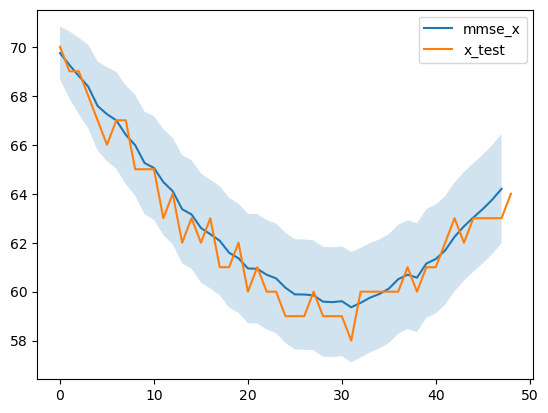

In [13]:
# lateral position X
plt.plot(mmse_x)
plt.plot(x_test[1:])
# plot the confidence interval
plt.fill_between(np.arange(output_length), mmse_x - 2 * mmse_x_std, mmse_x + 2 * mmse_x_std, alpha=0.2)
plt.legend(['mmse_x', 'x_test'])


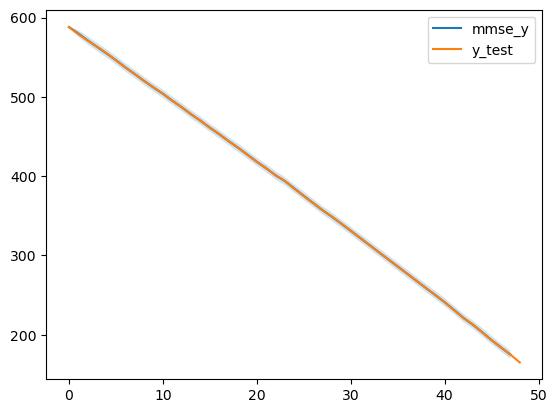

In [14]:
# longitudinal position Y
plt.plot(mmse_y)
plt.plot(y_test[1:])
# draw confidence interval 
plt.fill_between(np.arange(mmse_y.shape[0]), mmse_y - 2 * mmse_y_std, mmse_y + 2 * mmse_y_std, alpha=0.2)
plt.legend(['mmse_y', 'y_test'])

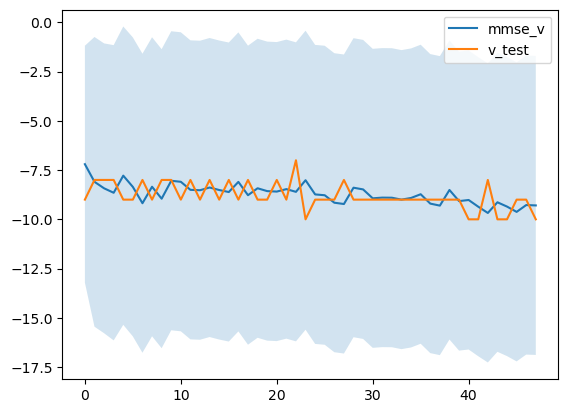

In [15]:
# velocity v 
plt.plot(mmse_v)
plt.plot(y_test[2:] - y_test[1:-1])
# draw confidence interval
plt.fill_between(np.arange(mmse_v.shape[0]), mmse_v - 2 * mmse_v_std, mmse_v + 2 * mmse_v_std, alpha=0.2)
plt.legend(['mmse_v', 'v_test'])

# Smoothing

In [16]:
# clone smoothie for easy debugging
import copy
smoothicc = copy.deepcopy(smoothie)
smoothicc.init_smoothie()
print('Cloning successful!')

Cloning successful!


In [17]:
# lateral component
#for bk in range(smoothicc.t): # first iteration is from N-1
xs_log = [] # first element corresponds to N-1 !!!
ps_log = []
ws_log = []

# longitudinal component
mys_log = [] # mean
pys_log = [] # covariance

for bk in range(smoothicc.t):
    k = smoothicc.t - bk - 1
    print('Loop\'s k = ', k, ', t_s = ', smoothicc.t_s)
    print('At k+1 = ', k+1, ', measurement is ', x_test[k+1])
    print('At k = ', k, ', measurement is ', x_test[k])
    # Lateral component
    xs, ps, ws, dbgObj = smoothicc.smooth_measurement_x(x_test[k+1]) # first measurement will be x_test[N] 
    xs_log.append(xs)
    ps_log.append(ps)
    ws_log.append(ws)
    # *** For debugging ***
    # if bk == 3:
    #     break
    
    # Longitudinal component
    if k == smoothicc.t - 1:
        mys, pys = smoothicc.smooth_measurement_y_rts()
    else:
        mys, pys = smoothicc.smooth_measurement_y_rts(mys, pys)
    mys_log.append(mys)
    pys_log.append(pys)
    print('------------------')


Loop's k =  47 , t_s =  47
At k+1 =  48 , measurement is  63.0
At k =  47 , measurement is  63.0
SmoothIE's k =  47
********************************
*** After measurement update ***
P_kPlus1_kPlus1 =  [9.]
mu_kPlus1_kPlus1 =  [63.]
********************************
*** After backward prediction ***
L_k_kPlus1 =  [0.11098779 0.11098779 0.11098779]
s_k_kPlus1 =  [-7.08842027 -6.92193859 -6.7554569 ]
t_k_kPlus1 =  [463.72036382 436.92408202 422.1887323 ]
*** After backward prediction ***
P_k_kPlus1 =  [9.01 9.01 9.01]
mu_k_kPlus1 =  [63.86666667 62.36666667 60.86666667]
w_k_kPlus1 =  [0.05 0.9  0.05]
********************************
*** After pruning of mixture components ***
P_k_kPlus1 =  [9.01 9.01 9.01]
mu_k_kPlus1 =  [63.86666667 62.36666667 60.86666667]
w_k_kPlus1 =  [0.05 0.9  0.05]
Expectation:  62.36666666665964
*** Filter state for fusion ***
index_of_array_of_filter =  46
x_filter =  [61.92458333 63.09232253 65.20805902 64.10933728 66.38710538]
P_filter =  [0.61731404 0.41934146 

TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'

## MMSEs from the Smoother

In [ ]:
# lateral component
mmse_x_smooth = np.zeros(output_length)
# reverse the log variables
xs_log_reverse = xs_log[::-1]
ps_log_reverse = ps_log[::-1]
ws_log_reverse = ws_log[::-1]
mmse_x_smooth_std = np.zeros(output_length)

# longitudinal component
mys_log_reverse = mys_log[::-1]
pys_log_reverse = pys_log[::-1]
mmse_y_smooth = np.zeros(output_length)
mmse_v_smooth = np.zeros(output_length)
mmse_y_smooth_std = np.zeros(output_length)
mmse_v_smooth_std = np.zeros(output_length)

# compute the mmse 
for i in range(output_length):
    mmse_x_smooth[i] = np.sum(np.array(ws_log_reverse[i]) * np.array(xs_log_reverse[i]))
    mmse_x_smooth_std = np.sqrt(get_var_from_mixture(xs_log_reverse[i], ps_log_reverse[i], ws_log_reverse[i]))
    mmse_y_smooth[i] = mys_log_reverse[i][0]
    mmse_v_smooth[i] = mys_log_reverse[i][1]
    mmse_y_smooth_std[i] = np.sqrt(pys_log_reverse[i][0,0])
    mmse_v_smooth_std[i] = np.sqrt(pys_log_reverse[i][1,1])

In [ ]:
plt.plot(mmse_x)
# plot the confidence interval
plt.fill_between(np.arange(output_length), mmse_x - 2 * mmse_x_std, mmse_x + 2 * mmse_x_std, alpha=0.2)
# plt.plot(x_test[1:])
plt.plot(mmse_x_smooth)
# plot the confidence interval
plt.fill_between(np.arange(output_length), mmse_x_smooth - 2 * mmse_x_smooth_std, mmse_x_smooth + 2 * mmse_x_smooth_std, alpha=0.2)
# plt.plot(x_mean + mmse_x_smooth[-1] - x_mean[-2])
plt.plot(x_test[1:])
plt.legend(['mmse_x', 'mmse_x_smooth', 'x_test'])

In [ ]:
plt.plot(mmse_y)
# plot the confidence interval
plt.fill_between(np.arange(output_length), mmse_y - 2 * mmse_y_std, mmse_y + 2 * mmse_y_std, alpha=0.2)
# plt.plot(y_test[1:])
plt.plot(mmse_y_smooth)
# plot the confidence interval
plt.fill_between(np.arange(output_length), mmse_y_smooth - 2 * mmse_y_smooth_std, mmse_y_smooth + 2 * mmse_y_smooth_std, alpha=0.2)
# plt.plot(y_mean + mmse_y_smooth[-1] - y_mean[-2])
plt.plot(y_test[1:])
plt.legend(['mmse_y', 'mmse_y_smooth', 'y_test'])

In [ ]:
len(smoothicc.mu_y_post)

In [ ]:
x_test.shape

In [ ]:
smoothicc.mu_y_post[smoothicc.t-1]